In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from PIL import Image


In [ ]:
#ocultar
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CAMINHO_DATASET =  '/content/drive/MyDrive/Caltech101/Caltech101/train'

In [ ]:
# Função para carregar o dataset com subpastas
def load_images_from_folder(folder, valid_folders=[]):
    images = []
    file_paths = []

    # Iterando sobre todas as subpastas (classes) dentro da pasta principal
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)

        # Verifica se é uma pasta
        if os.path.isdir(subfolder_path) and subfolder in valid_folders:
            # Itera sobre todas as imagens dentro da subpasta
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)

                # Verifica se o arquivo é uma imagem
                if os.path.isfile(img_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(img_path).resize((224, 224))  # Tamanho necessário para o modelo ResNet50
                    images.append(img)
                    file_paths.append(img_path)

    return images, file_paths

In [ ]:
# Função para extrair características usando ResNet50
def extract_features(img, model):
    # Converter para RGB (caso a imagem não tenha 3 canais)
    img = img.convert('RGB')  # Garante que a imagem tem 3 canais

    # Redimensionar a imagem para o tamanho correto
    img_array = img.resize((224, 224))  # O modelo ResNet50 espera 224x224
    img_array = img_to_array(img_array)  # Converte a imagem para um array NumPy

    # Adicionar uma dimensão extra para a batch (necessário para o modelo)
    img_array = np.expand_dims(img_array, axis=0)

    # Pré-processamento para a ResNet50
    img_array = preprocess_input(img_array)

    # Obter as características da imagem usando o modelo
    features = model.predict(img_array)

    # Retornar o vetor de características como um vetor unidimensional
    return features.flatten()  # A função predict retorna um tensor 4D, então achatamos para 1D

In [ ]:
# Carregar as imagens e o modelo pré-treinado
valid_folders = ['Motorbikes','airplanes','cellphone']
images, file_paths = load_images_from_folder(CAMINHO_DATASET, valid_folders)

In [ ]:
# Carregar o modelo ResNet50 pré-treinado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Extrair as características de todas as imagens do dataset
features = []
for img in images:
    features.append(extract_features(img, model))

features = np.array(features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Usar NearestNeighbors para encontrar as imagens mais semelhantes
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')
nbrs.fit(features)

NearestNeighbors(metric='euclidean')

In [ ]:
# Função para encontrar imagens semelhantes para uma consulta
def find_similar_images(query_image_path, model, nbrs, dataset_folder):
    query_img = Image.open(query_image_path).resize((224, 224))
    query_features = extract_features(query_img, model)
    query_features = query_features.reshape(1, -1)  # Reformatação necessária para o NearestNeighbors

    # Encontrar as imagens mais próximas
    distances, indices = nbrs.kneighbors(query_features)

    # Mostrar as imagens mais semelhantes
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices[0]):
        img_path = file_paths[idx]
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Distância: {distances[0][i]:.2f}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


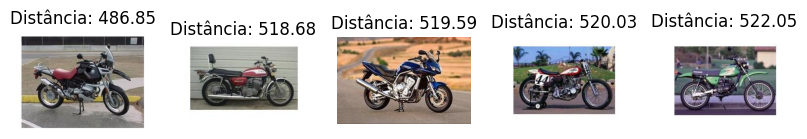

In [ ]:
# Exemplo de uso: Encontrar imagens semelhantes para uma imagem de consulta
find_similar_images('./cg-125-titan.jpg', model, nbrs, CAMINHO_DATASET)